In [ ]:
import gradio as gr

import os
import numpy as np
import glob
import time

from PIL import Image
from skimage.color import rgb2lab, lab2rgb
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet
from torchvision.models.resnet import resnet18

In [ ]:
!pip install fastai==2.4

     |████████████████████████████████| 187 kB 5.2 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading iamges from the drive
main_path = '/content/drive/MyDrive/dataset_image_colorization'
paths = glob.glob(main_path + "/*.jpg") 

In [ ]:
# Split Data in Training set and Validation set
# 80% of data in Training set and 20% in Validation set
# Validation set is used to adjust the Hyperparmeters such as learning rate, number of hidden layers etc

training_set, validation_set = train_test_split(paths, train_size = 0.80, random_state = 0)

In [ ]:
SIZE = 256

# Reshaping the images in Dataset
# with member functions to convert the given image from RGB to CIE LAB color space

class PreprocessDataset(Dataset):
    def __init__(self, paths, set_type):

        self.set_type = set_type
        self.paths = paths
        self.size = SIZE

        if set_type == 'training':
            self.transforms = transforms.Compose([
                # Resahpe the image and apply Bicubic Interpolation for smooth results                           
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC), 
                # Data Augmentation
                transforms.RandomHorizontalFlip(), 
            ])
        else:
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
    # invoked when calling obj[index] of this class
    def __getitem__(self, index):
        img_rgb = Image.open(self.paths[index]).convert("RGB")

        # Apply Transformation to the image
        img_rgb = self.transforms(img_rgb)
        img_rgb = np.array(img_rgb)

        # Converting RGB to CIE LAB color space
        img_lab_format = rgb2lab(img_rgb).astype("float32")
        img_lab_format = transforms.ToTensor()(img_lab_format)

        # normalize values between -1 and 1
        L_channel = img_lab_format[[0], ...] / 50.0 - 1.0
        ab_channels = img_lab_format[[1, 2], ...] / 110.0
        # try:
        #   ab_channels = img_lab_format[[1, 2], ...] / 110.0
        # except:
        #   ab_channels = np.zeroes((2,256,256))
        
        return {'L': L_channel, 'ab': ab_channels}
    
    # invoked when calling len(obj) of this class
    def __len__(self):
        return len(self.paths)

def CreateDataloader(paths, set_type):
    preprocessed_dataset = PreprocessDataset(paths, set_type)

    # Parallelizing the data loading process with batch size of 16 
    # This boosts up the speed and saves memory.
    data_loader = DataLoader(preprocessed_dataset, batch_size=16, num_workers=4, pin_memory=True)
    return data_loader

In [ ]:
training_dl = CreateDataloader(training_set,'training')
validation_dl = CreateDataloader(validation_set,'validation')

data = next(iter(training_dl)) # same as for loop, training_dl[index] calls __getitem__(index)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def createResUnet(n_input=1, n_output=2, size=256):

    # Check GPU Availability.
    # torch.cuda.is_available() returns True if the system has the Nvidia driver installed.

    device_used = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    resnet18_body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    G_network = DynamicUnet(resnet18_body, n_output, (size, size)).to(device_used)

    return G_network

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_channels, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_channels, num_filters, norm=False)]

        # the 'if' statement is taking care of not using
        # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)]

        # Make sure to not use normalization or
        # activation for the last layer of the model
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] 
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): 
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]   
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, ganLossMode='default', realLabel=1.0, fakeLabel=0.0):
        super().__init__()
        self.register_buffer('fake_label', torch.tensor(fakeLabel))
        self.register_buffer('real_label', torch.tensor(realLabel))

        if ganLossMode == 'default':
            # BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class.
            # BCE loss stands for Binary Cross-Entropy Loss
            self.loss = nn.BCEWithLogitsLoss()
        else:
            #Mean squared error Loss
            self.loss = nn.MSELoss()
    
    def get_labels(self, predictions, is_target_real):
        if is_target_real == True:
            Label = self.real_label
        else:
            Label = self.fake_label
        return Label.expand_as(predictions)
    
    # invokes when the object to this class is called as a function
    def __call__(self, predictions, target_is_real):
        labels = self.get_labels(predictions, target_is_real)
        loss = self.loss(predictions, labels)
        return loss

In [ ]:
def initializeWeights(network, init='norm', gain=0.02):
    
    # helper Function
    def initFunction(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    network.apply(initFunction)
    print(f"model initialized with {init} initialization")
    return network

def initializeModel(model, device_type):
    model = model.to(device_type)
    model = initializeWeights(model)
    return model

In [ ]:
class InitializeModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G:
            self.net_G = net_G.to(self.device_type)
        else:
            self.net_G = initializeModel(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device_type)

        self.net_D = initializeModel(PatchDiscriminator(input_channels=3, n_down=3, num_filters=64), self.device_type)
        self.GANcriterion = GANLoss(ganLossMode='default').to(self.device_type)
        self.L1criterion = nn.L1Loss()

        # Optimization using Adaptive Momemt Estimation (Adam)
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def setRequiresGradient(self, model, requires_gradient=True):
        for para in model.parameters():
            para.requires_grad = requires_gradient
        
    def setupInputValues(self, data):
        self.L = data['L'].to(self.device_type)
        self.ab = data['ab'].to(self.device_type)
        
    # forward Propagation for Generator
    def forward(self):
        self.fake_color = self.net_G(self.L)

    # Backword Propagation for Generator
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)

        # percentage for how fake the genearted image looks
        fake_preds = self.net_D(fake_image)

        # calculate the losses for Generator
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1

        # update the loss for Generator
        self.loss_G.backward()
    
    
    # Backword Propagation for Discriminator
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)

        # percentage for classifying fake image as a real image
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)

        real_image = torch.cat([self.L, self.ab], dim=1)
        
        # percentage for classifying real image as a fake image
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)

        # calculate the loss for Discriminator
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def optimize(self):
        # optimize Discriminator
        self.forward()
        self.net_D.train()
        self.setRequiresGradient(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        # optimize Generator
        self.net_G.train()
        self.setRequiresGradient(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [ ]:
class LossMeter:
    def __init__(self):
        self.reset_value()
        
    def reset_value(self):
        self.count, self.average, self.sum = [0.] * 3
    
    def update_value(self, value, count=1):
        self.count += count
        self.sum += count * value
        self.average = self.sum / self.count

def createLossMeters():
    return {'loss_D_fake': LossMeter(),
            'loss_D_real': LossMeter(),
            'loss_D': LossMeter(),
            'loss_G_GAN': LossMeter(),
            'loss_G_L1': LossMeter(),
            'loss_G': LossMeter()}

def updateLosses(model, loss_dict, count):
    for loss_type, loss_meter in loss_dict.items():
        loss = getattr(model, loss_type)
        loss_meter.update_value(loss.item(), count=count)

def lab_to_rgb(L, ab):
    # scale up the normalized values
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_images = []
    for image in Lab:
        image_rgb = lab2rgb(image)
        rgb_images.append(image_rgb)
    return np.stack(rgb_images, axis=0)
    
# Visualize the results while Training
def visualize(model, data):
    model.net_G.eval()
    with torch.no_grad():
        model.setupInputValues(data)
        model.forward()
    model.net_G.train()

    # Generated ab Channels
    fake_color = model.fake_color.detach()
    # Ground Truth for ab Channel
    real_color = model.ab

    L = model.L
    
    # RGB images churned out by Generator
    fake_imgs = lab_to_rgb(L, fake_color)
    # Ground Truth for generated Images
    real_imgs = lab_to_rgb(L, real_color)

    # Plot b\w image , Generated image and Ground Truth
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
 
def logResults(loss_dict):
    # print Loss values
    for loss_type, loss_meter in loss_dict.items():
        print(f"{loss_type}: {loss_meter.average:.5f}")

In [ ]:
def predict(model, data):
    with torch.no_grad():
        model.setupInputValues(data)
        model.forward()

    # Genearted ab Channels
    generated_ab = model.fake_color.detach()
    L = model.L

    generated_imgs = lab_to_rgb(L, generated_ab)
    return generated_imgs[0] if len(data) == 2 else generated_imgs
 

In [ ]:
def pretrainGenerator(net_G, training_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = LossMeter()
        for data in tqdm(training_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            predictions = net_G(L)
            loss = criterion(predictions, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update_value(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.average:.5f}")

net_G = createResUnet(n_input=1, n_output=2, size=256)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
pretrainGenerator(net_G, training_dl, opt, criterion, 1)

In [ ]:
net_G.load_state_dict(torch.load("/content/drive/MyDrive/res18-unet.pt", map_location=device))
model = InitializeModel(net_G=net_G)
model.load_state_dict(torch.load("/content/drive/MyDrive/img_colorization_res18-unet.pt", map_location=device))

model initialized with norm initialization


<All keys matched successfully>

In [ ]:
p = '/content/drive/MyDrive/ae256_2.jpg'
input_img = CreateDataloader([p, p],'training')

data = next(iter(input_img))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


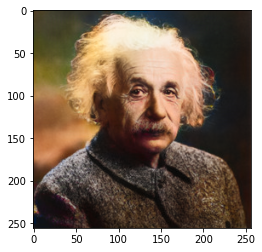

In [ ]:
predict(model, data)

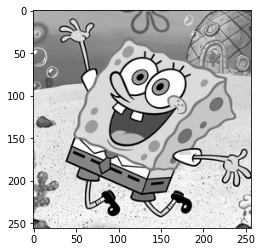

In [ ]:
p = '/content/drive/MyDrive/s256_2.jpg'
input_img = Image.open(p)
plt.imshow(input_img)

In [ ]:
img_dl = CreateDataloader([p, p],'training')
data = next(iter(img_dl))
result = predict(model, data)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 19 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


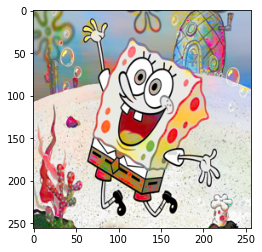

In [ ]:
plt.imshow(result)

# Generation of colored images on HIgh Resolution Images

In [ ]:
p = '/content/drive/MyDrive/mountain_bw.jpg'
input_img = Image.open(p).convert("RGB")
plt.imshow(input_img)

NameError: ignored

In [ ]:
height, width = input_img.shape

In [ ]:
print(height, width)

846 1410


In [ ]:

from math import ceil
div_h = ceil(height/256)
div_w = ceil(width/256)

In [ ]:
new_height = div_h*256
new_width = div_w*256
offset_h = new_height - height
offset_w = new_width - width

In [ ]:
print(offset_h, offset_w)

178 126


<PIL.Image.Image image mode=RGB size=1410x846 at 0x7F710FDA9D50>


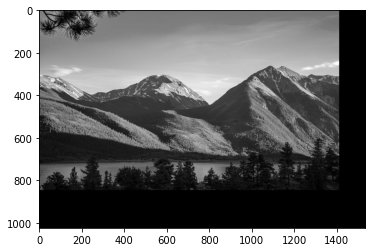

In [ ]:
padded_img = Image.new(input_img.mode, (new_width, new_height), (0, 0, 0))
print(input_img)
padded_img.paste(input_img, (0, 0))
plt.imshow(padded_img)

In [ ]:
import os

In [ ]:
path_list = []
for i in range(0,new_height,256):
  for j in range(0,new_width,256):
    box = (j, i, j+256, i+256)
    crp = padded_img.crop(box)
    crp_img_name = '/content/temp/' + str(i) + str(j) + '.jpg'
    crp.save(crp_img_name)
    path_list.append([crp_img_name, crp_img_name])
    


In [ ]:
print(path_list)

[['/content/temp/00.jpg', '/content/temp/00.jpg'], ['/content/temp/0256.jpg', '/content/temp/0256.jpg'], ['/content/temp/0512.jpg', '/content/temp/0512.jpg'], ['/content/temp/0768.jpg', '/content/temp/0768.jpg'], ['/content/temp/01024.jpg', '/content/temp/01024.jpg'], ['/content/temp/01280.jpg', '/content/temp/01280.jpg'], ['/content/temp/2560.jpg', '/content/temp/2560.jpg'], ['/content/temp/256256.jpg', '/content/temp/256256.jpg'], ['/content/temp/256512.jpg', '/content/temp/256512.jpg'], ['/content/temp/256768.jpg', '/content/temp/256768.jpg'], ['/content/temp/2561024.jpg', '/content/temp/2561024.jpg'], ['/content/temp/2561280.jpg', '/content/temp/2561280.jpg'], ['/content/temp/5120.jpg', '/content/temp/5120.jpg'], ['/content/temp/512256.jpg', '/content/temp/512256.jpg'], ['/content/temp/512512.jpg', '/content/temp/512512.jpg'], ['/content/temp/512768.jpg', '/content/temp/512768.jpg'], ['/content/temp/5121024.jpg', '/content/temp/5121024.jpg'], ['/content/temp/5121280.jpg', '/content

In [ ]:
results = []
for path in path_list:
  img_dl = CreateDataloader(path,'test')
  data = next(iter(img_dl))
  r = predict(model, data)
  results.append(r)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWa

In [ ]:
print(len(results))
print(type(results[0]))

24
<class 'numpy.ndarray'>


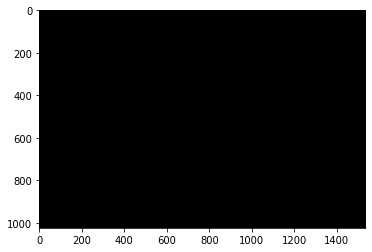

In [ ]:
final_img = Image.new("RGB", (new_width, new_height), (0, 0, 0))
plt.imshow(final_img)

In [ ]:
# from matplotlib import cm
k = 0
for i in range(0,new_height,256):
  for j in range(0,new_width,256):
    r = Image.fromarray((results[k]*255).astype(np.uint8))
    # plt.imshow(r)
    final_img.paste(r, (j, i))
    k +=1

1410 846


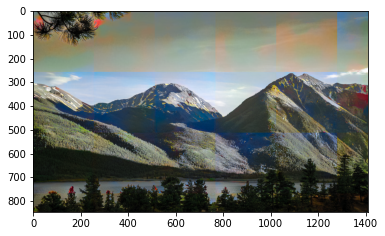

In [ ]:
print(width, height)
final_img = final_img.crop((0,0, width, height))
plt.imshow(final_img)

In [ ]:
# path_list = []
# for i in range(0,new_height,256):
#   for j in range(0,new_width,256):
#     # box = (j, i, j+256, i+256)
#     # crp = padded_img.crop(box)
#     crp_img_name = '/content/temp/' + str(i) + str(j) + '.jpg'
#     # crp.save('/content/temp/' + crp_img_name)
#     os.remove(crp_img_name)